<a href="https://colab.research.google.com/github/AnandNimmalapudi/OPSC/blob/main/Crowd%20Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [ ]:
META_FILE = '/content/labels.csv'

In [ ]:
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'

In [ ]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'../input/crowd-counting/frames/frames/seq_{image_id}.jpg'


def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)


def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()


def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size

    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image


def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [ ]:
set_display()

In [ ]:
data = pd.read_csv(META_FILE)
data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,../input/crowd-counting/frames/frames/seq_0000...
1,2,41,../input/crowd-counting/frames/frames/seq_0000...
2,3,41,../input/crowd-counting/frames/frames/seq_0000...
3,4,44,../input/crowd-counting/frames/frames/seq_0000...
4,5,41,../input/crowd-counting/frames/frames/seq_0000...


In [ ]:
stats = data.describe()
stats

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


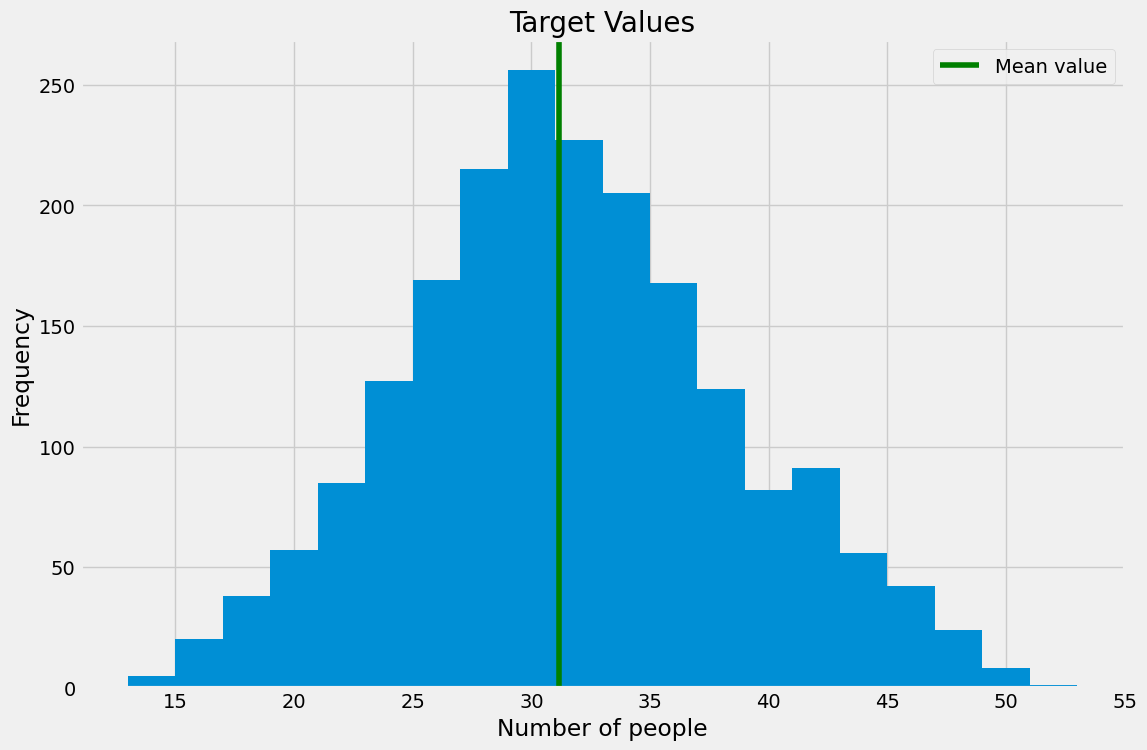

In [ ]:
plt.hist(data['count'], bins=20)
plt.axvline(stats.loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [ ]:
detector = hub.load(MODEL_PATH)

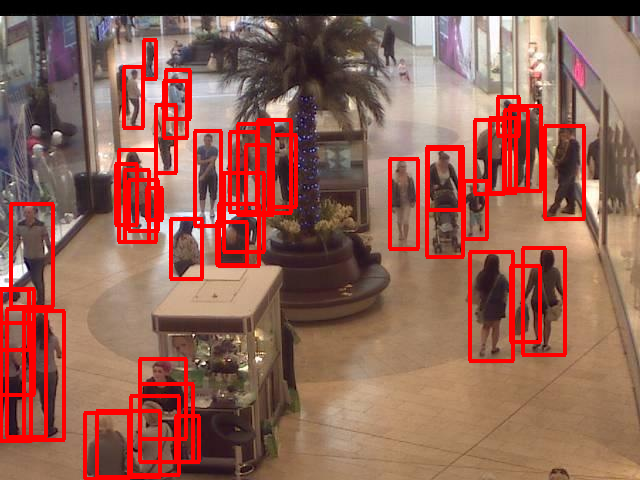

In [ ]:
# Object detection with no confidence threshold results in
# duplicate bounding boxes and false positives.
# Total number of people in an image is overestimated.
# Some mannequins are erroneously marked as people.
example_path = '/content/frames/frames/seq_000002.jpg'
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results)

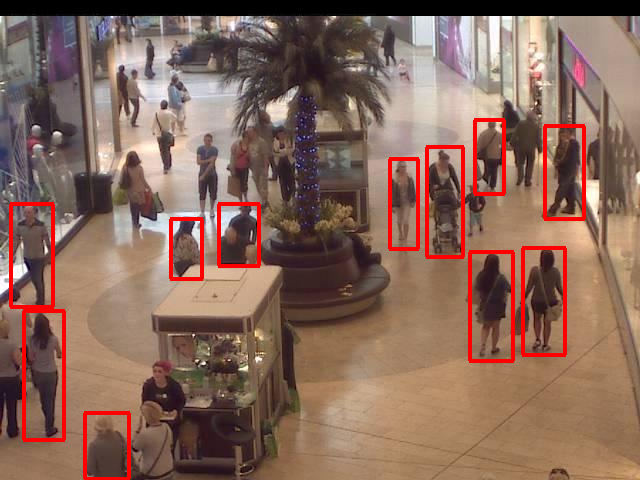

In [ ]:
draw_bboxes(example_path, results, threshold=0.5)

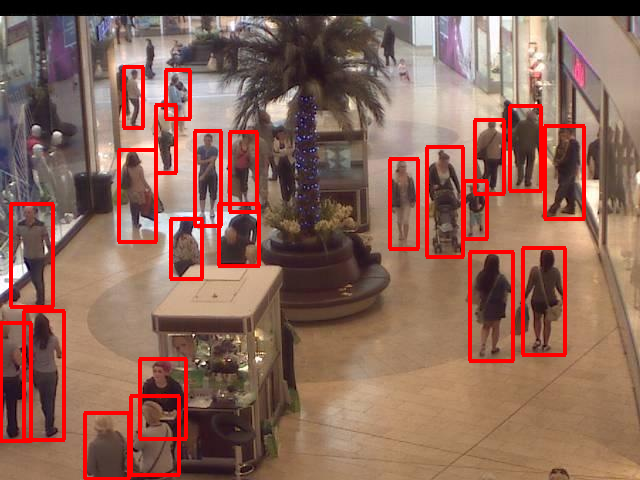

In [ ]:
draw_bboxes(example_path, results, threshold=0.25)